<a href="https://colab.research.google.com/github/YuliaLoburets/ML_learning/blob/main/HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls drive/MyDrive/ML/train.csv

drive/MyDrive/ML/train.csv


In [ ]:
train = pd.read_csv('drive/MyDrive/ML/train.csv')

In [ ]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['Exited'])

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [ ]:
input_cols = train_df.columns.difference(['id','CustomerId','Surname','Exited'])
target_col = 'Exited'
input_cols

Index(['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'Gender',
       'Geography', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure'],
      dtype='object')

In [ ]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = valid_df[input_cols]
val_targets = valid_df[target_col]

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [ ]:
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
categorical_cols

['Gender', 'Geography']

In [ ]:
binary_cols = ['HasCrCard','IsActiveMember']

In [ ]:
numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
numeric_cols

['Age',
 'Balance',
 'CreditScore',
 'EstimatedSalary',
 'HasCrCard',
 'IsActiveMember',
 'NumOfProducts',
 'Tenure']

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [ ]:
train_inputs.isnull().sum()

,0
Age,0
Balance,0
CreditScore,0
EstimatedSalary,0
Gender,0
Geography,0
HasCrCard,0
IsActiveMember,0
NumOfProducts,0
Tenure,0


In [ ]:
val_inputs.isnull().sum()

,0
Age,0
Balance,0
CreditScore,0
EstimatedSalary,0
Gender,0
Geography,0
HasCrCard,0
IsActiveMember,0
NumOfProducts,0
Tenure,0


Пропущенних значень немає

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
scaler = StandardScaler().set_output(transform='pandas')

In [ ]:
train_inputs['HasCrCard'].value_counts()

,count
HasCrCard,
1.0,9484
0.0,2516


In [ ]:
train_inputs['IsActiveMember'].value_counts()

,count
IsActiveMember,
0.0,6101
1.0,5899


Колонки HasCrCard та IsActiveMember мають бінарні значення 0 та 1, тому масштабувати їх не потрібно.

In [ ]:
columns_to_scale = np.setdiff1d(numeric_cols,binary_cols).tolist()
columns_to_scale

['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'NumOfProducts', 'Tenure']

In [ ]:
scaler.fit(train_inputs[columns_to_scale])

StandardScaler()

In [ ]:
scaler.mean_.tolist()

[37.687916666666666,
 43008.174362499994,
 658.84025,
 117992.400015,
 1.59025,
 5.026083333333333]

In [ ]:
train_inputs.head()

,Age,Balance,CreditScore,EstimatedSalary,Gender,Geography,HasCrCard,IsActiveMember,NumOfProducts,Tenure
7180,30.0,131394.56,682.0,143952.24,Male,France,1.0,1.0,1.0,1.0
10393,39.0,178058.06,684.0,145518.31,Female,France,1.0,0.0,1.0,2.0
80,35.0,116320.68,705.0,174431.01,Male,Germany,1.0,0.0,2.0,6.0
3365,58.0,0.00,669.0,51565.98,Male,Spain,0.0,1.0,2.0,0.0
12236,21.0,0.00,707.0,148564.76,Male,France,1.0,1.0,2.0,3.0


In [ ]:
train_inputs[columns_to_scale] = scaler.transform(train_inputs[columns_to_scale])
val_inputs[columns_to_scale] = scaler.transform(val_inputs[columns_to_scale])

In [ ]:
train_inputs.head()

,Age,Balance,CreditScore,EstimatedSalary,Gender,Geography,HasCrCard,IsActiveMember,NumOfProducts,Tenure
7180,-0.944682,1.475464,0.320187,0.569450,Male,France,1.0,1.0,-1.108193,-1.447264
10393,0.161227,2.254434,0.347838,0.603803,Female,France,1.0,0.0,-1.108193,-1.087792
80,-0.330288,1.223831,0.638166,1.238026,Male,Germany,1.0,0.0,0.769304,0.350096
3365,2.495924,-0.717950,0.140460,-1.457116,Male,Spain,0.0,1.0,0.769304,-1.806736
12236,-2.050591,-0.717950,0.665816,0.670629,Male,France,1.0,1.0,0.769304,-0.728320


In [ ]:
from sklearn import preprocessing
encoder = preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [ ]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [ ]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['France', 'Germany', 'Spain'], dtype=object)]

In [ ]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']


In [ ]:
encoder.transform(train_inputs[categorical_cols])[:10]

array([[0., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 0.]])

In [ ]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
display(train_inputs[:5])

,Age,Balance,CreditScore,EstimatedSalary,Gender,Geography,HasCrCard,IsActiveMember,NumOfProducts,Tenure,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
7180,-0.944682,1.475464,0.320187,0.569450,Male,France,1.0,1.0,-1.108193,-1.447264,0.0,1.0,1.0,0.0,0.0
10393,0.161227,2.254434,0.347838,0.603803,Female,France,1.0,0.0,-1.108193,-1.087792,1.0,0.0,1.0,0.0,0.0
80,-0.330288,1.223831,0.638166,1.238026,Male,Germany,1.0,0.0,0.769304,0.350096,0.0,1.0,0.0,1.0,0.0
3365,2.495924,-0.717950,0.140460,-1.457116,Male,Spain,0.0,1.0,0.769304,-1.806736,0.0,1.0,0.0,0.0,1.0
12236,-2.050591,-0.717950,0.665816,0.670629,Male,France,1.0,1.0,0.769304,-0.728320,0.0,1.0,1.0,0.0,0.0


In [ ]:
display(val_inputs[:5])

,Age,Balance,CreditScore,EstimatedSalary,Gender,Geography,HasCrCard,IsActiveMember,NumOfProducts,Tenure,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
6490,1.021379,1.214543,0.762592,-0.988144,Male,Germany,1.0,1.0,4.524299,-1.447264,0.0,1.0,0.0,1.0,0.0
3646,0.406985,-0.717950,-0.910252,-1.750392,Male,France,1.0,1.0,0.769304,-0.009376,0.0,1.0,1.0,0.0,0.0
5306,0.038348,-0.717950,0.997620,-0.022404,Female,France,0.0,1.0,0.769304,-1.087792,1.0,0.0,1.0,0.0,0.0
652,0.652742,1.881867,0.195761,-0.139723,Female,France,0.0,1.0,-1.108193,-0.368848,1.0,0.0,1.0,0.0,0.0
2627,-0.944682,-0.717950,0.264887,0.563519,Female,Spain,1.0,0.0,0.769304,-0.368848,1.0,0.0,0.0,0.0,1.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [ ]:
print('train_inputs:', train_inputs.shape)
print('val_inputs:', val_inputs.shape)

train_inputs: (12000, 15)
val_inputs: (3000, 15)


In [ ]:
!pip install pyarrow --quiet

In [ ]:
train_inputs.to_parquet('train_inputs.parquets')
val_inputs.to_parquet('val_inputs.parquets')
pd.DataFrame(train_targets).to_parquet('train_targets.parquets')
pd.DataFrame(val_targets).to_parquet('val_targets.parquets')

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.listdir('/content')

['.config',
 'train_targets.parquets',
 'val_inputs.parquets',
 'drive',
 'val_targets.parquets',
 'train_inputs.parquets',
 'customer_churn.joblib',
 'sample_data']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [ ]:
X_train = train_inputs[encoded_cols+columns_to_scale+binary_cols]
X_val = val_inputs[encoded_cols+columns_to_scale+binary_cols]

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(solver='liblinear')

In [ ]:
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [ ]:
print(X_train.columns)

Index(['Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Age', 'Balance', 'CreditScore', 'EstimatedSalary',
       'NumOfProducts', 'Tenure', 'HasCrCard', 'IsActiveMember'],
      dtype='object')


In [ ]:
model.coef_.round(3)

array([[ 0.156, -0.716, -0.686,  0.91 , -0.784,  1.292, -0.327, -0.154,
         0.048, -0.722, -0.019, -0.188, -1.279]])

In [ ]:
model.intercept_

array([-0.56043761])

In [ ]:
train_pred = model.predict(X_train)

In [ ]:
train_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
val_pred = model.predict(X_val)

In [ ]:
val_pred

array([0., 0., 0., ..., 0., 0., 0.])

(array([10259.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1741.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

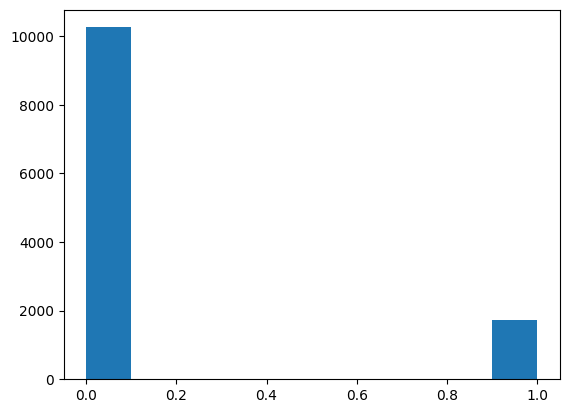

In [ ]:
plt.hist(train_pred)

(array([2527.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         473.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

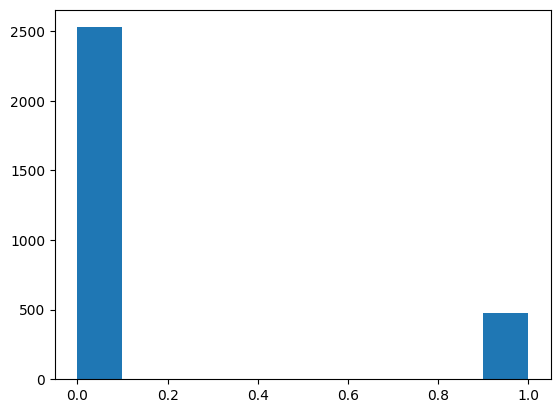

In [ ]:
plt.hist(val_pred)

In [ ]:
train_proba = model.predict_proba(X_train)

(array([6450., 1863.,  878.,  598.,  451.,  421.,  310.,  314.,  371.,
         344.]),
 array([0.00113839, 0.10041703, 0.19969567, 0.29897431, 0.39825295,
        0.49753159, 0.59681023, 0.69608888, 0.79536752, 0.89464616,
        0.9939248 ]),
 <BarContainer object of 10 artists>)

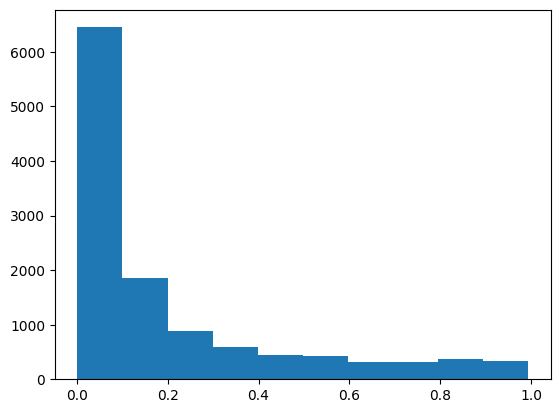

In [ ]:
plt.hist(train_proba[:,1])

In [ ]:
val_proba = model.predict_proba(X_val)

(array([1562.,  463.,  227.,  143.,  130.,   97.,   92.,   97.,  105.,
          84.]),
 array([0.00111155, 0.10032688, 0.19954221, 0.29875753, 0.39797286,
        0.49718819, 0.59640351, 0.69561884, 0.79483417, 0.89404949,
        0.99326482]),
 <BarContainer object of 10 artists>)

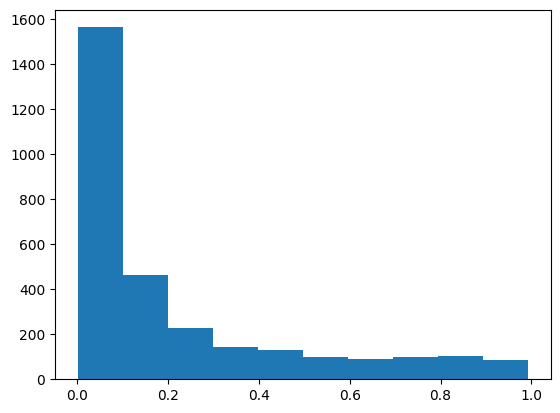

In [ ]:
plt.hist(val_proba[:,1])

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [ ]:
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, f1_score,accuracy_score)

In [ ]:
threshold = 0.5
train_pred_threshold = (train_proba[:,1]>0.5).astype('int')
val_pred_threshold = (val_proba[:,1]>0.5).astype('int')

In [ ]:
def calculation(targets, prediction, df):
  acc_score = accuracy_score(targets,prediction)
  f1 = f1_score(targets,prediction)
  confusion_mx=confusion_matrix(targets,prediction,normalize='true')
  plt.figure()
  sns.heatmap(confusion_mx, annot=True)
  plt.xlabel('Prediction')
  plt.ylabel('Target')
  plt.title(f'Confusion matrix for {df} data')
  plt.show()

  fpr, tpr, thresholds = roc_curve(targets,  prediction)

  roc_auc = auc(fpr, tpr)


  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {df} data')
  plt.legend(loc="lower right")
  plt.show()



  print(f"Accuracy score for {df} data: {acc_score}")
  print(f"F1 score for {df} data: {f1:.2f}%")
  print(f'AUROC for {df} data: {roc_auc:.2f}')

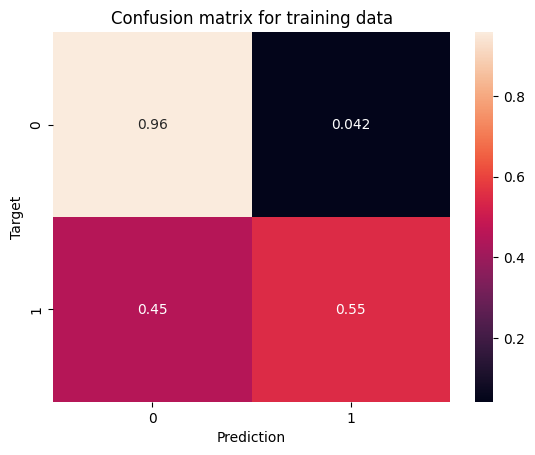

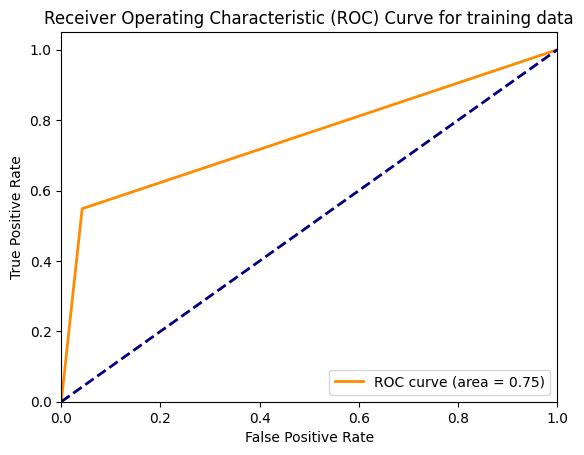

Accuracy score for training data: 0.8745833333333334
F1 score for training data: 0.64%
AUROC for training data: 0.75


In [ ]:
calculation(targets=train_targets, prediction=train_pred_threshold,df='training')

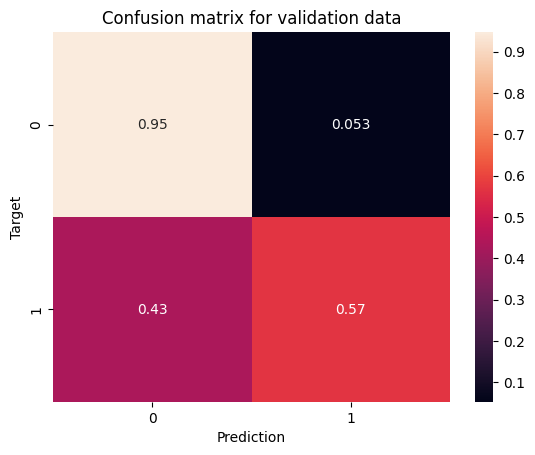

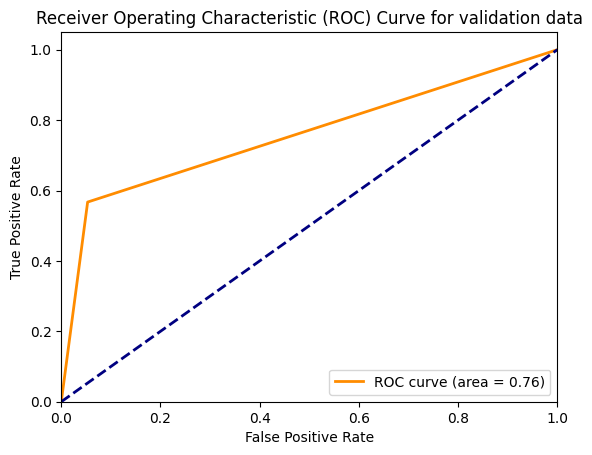

Accuracy score for validation data: 0.8696666666666667
F1 score for validation data: 0.64%
AUROC for validation data: 0.76


In [ ]:
calculation(targets=val_targets, prediction=val_pred_threshold,df='validation')

В цілому модель непогана, враховуючи показники

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [ ]:
from collections import Counter
majority_class = Counter(train_targets).most_common(1)[0][0]
print(f"Мажоритарний клас: {majority_class}")

Мажоритарний клас: 0.0


In [ ]:
y_pred_train = [majority_class] * len(X_train)
y_pred_val = [majority_class] * len(X_val)

In [ ]:
def accuracy_calc(targets,prediction,df):
    acc_score = accuracy_score(targets,prediction)
    print(f"Accuracy score for {df} data: {acc_score}")

In [ ]:
accuracy_calc(targets=train_targets, prediction=train_pred,df='training')
accuracy_calc(targets=val_targets, prediction=val_pred,df='validation')

Accuracy score for training data: 0.8745833333333334
Accuracy score for validation data: 0.8696666666666667


In [ ]:
accuracy_calc(targets=train_targets, prediction=y_pred_train,df='majority class training')
accuracy_calc(targets=val_targets, prediction=y_pred_val,df='majority class validation')

Accuracy score for majority class training data: 0.7965
Accuracy score for majority class validation data: 0.7966666666666666


Accuracy score показує високе значення і для моделі , яка передбачає лише мажоритарний клас. Але у нашої моделі із threshold 0.5 даний показник має вище значення, що в цілому непогано, але є можливість ще її покращити.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [ ]:
import joblib

In [ ]:
customer_churn ={
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'columns_to_scale': columns_to_scale,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'binary_cols': binary_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [ ]:
joblib.dump(customer_churn, 'customer_churn.joblib')

['customer_churn.joblib']

In [ ]:
model_2 = joblib.load('customer_churn.joblib')

In [ ]:
val_pred_test = model_2['model'].predict(X_val)

In [ ]:
acc_score_val = accuracy_score(val_targets, val_pred_test)

In [ ]:
acc_score_val

0.8696666666666667

Модель завантажилась коректно - accuracy score співпадає

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, binary_cols, input_df: pd.DataFrame):
    columns_to_scale = np.setdiff1d(numeric_cols,binary_cols).tolist()
    input_df[columns_to_scale] = scaler.transform(input_df[columns_to_scale])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[encoded_cols+columns_to_scale+binary_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [ ]:
test_raw_df = pd.read_csv('drive/MyDrive/ML/test.csv')

In [ ]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [ ]:
predicted_values=predict_raw_df(scaler, encoder, numeric_cols, categorical_cols,binary_cols, test_raw_df)

In [ ]:
predicted_values

array([0.06944496, 0.0333476 , 0.15341441, ..., 0.01657754, 0.1519725 ,
       0.08801884])

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [ ]:
sample = pd.read_csv('drive/MyDrive/ML/sample_submission.csv')

In [ ]:
predicted_values

array([0.06944496, 0.0333476 , 0.15341441, ..., 0.01657754, 0.1519725 ,
       0.08801884])

In [ ]:
sample.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [ ]:
sample.shape

(10000, 2)

In [ ]:
sample.drop(columns='Exited', inplace=True)

In [ ]:
sample.head()

,id
0,15000
1,15001
2,15002
3,15003
4,15004


In [ ]:
pred_dataframe = pd.DataFrame(predicted_values)
pred_dataframe.rename(columns={0:'Exited'}, inplace=True)
pred_dataframe.head()

,Exited
0,0.069445
1,0.033348
2,0.153414
3,0.199254
4,0.054301


In [ ]:
submission_log_reg = pd.concat([sample,pred_dataframe], axis=1).reset_index(drop=True)
submission_log_reg.head()

,id,Exited
0,15000,0.069445
1,15001,0.033348
2,15002,0.153414
3,15003,0.199254
4,15004,0.054301


In [ ]:
file_path = '/content/drive/MyDrive/ML/submission_log_reg.csv'
submission_log_reg.to_csv(file_path, index=False)